Based on the following links to create this notebook:

https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy#scrollTo=bhsj7BTPHepg

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy


To run Gym, you have to install prerequisites like xvbf,opengl & other python-dev packages using the following codes.

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [ ]:
!pip install gym  torch
!apt-get install python-opengl ffmpeg -y 
!apt install xvfb -y 
!pip install pyvirtualdisplay  
!pip install piglet 
!pip install gym[box2d] 
!pip install tensorflow 


In [1]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


In [2]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
# import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [41]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

def make_noise():
    mu, sigma = 0, 0.05 # mean and standard deviation
    return np.random.normal(mu, sigma, 1)[0]


0.07796053055748166

# My Code

In [5]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [44]:
class defaultActions:
    def __init__(self):

        self.main = [[0 , "Main off"],
                     [0.5 ,"Main slow"],
                     [0.75 , "Main meduim"],
                     [1    , "Main strong"]
                    ]
        self.left_right = [
                        [0, "Left Right off"],
                        [-0.5 , "Left slow"],
                        [-0.75  , "Left meduim"],
                        [-1 , "Left strong"],
                        
                        [0.5 , "Right slow"],
                        [0.75  , "Right meduim"],
                        [1 , "Right strong"],
                        ]
        self.all_actions = {}
        i = 0  
        for main_eng in self.main:
            for sec_eng in self.left_right:
#                 print (f"a{i},act:[{main_eng[0]},{sec_eng[0]},{main_eng[1]} {sec_eng[1]}]")
                self.all_actions[i] = [[main_eng[0],sec_eng[0]] , f"{main_eng[1]}, {sec_eng[1]}"]
                i+=1
        
    def get_full_action(self,id):
        return self.all_actions[id]

    def get_action(self,id,add_noise=True):
        if add_noise :
            return [self.all_actions[id][0][0]+make_noise(), self.all_actions[id][0][1]+make_noise()]
        else:
            return self.all_actions[id][0]

    def get_description(self,id):
        return self.all_actions[id][1]
    def get_action_count(self):
        return len(self.all_actions)
actions = defaultActions()
actions.get_action_count()


28

In [7]:
class model(nn.Module):
    def __init__(self, layers, name=""):
        super(model, self).__init__()
        self.name = ""
        self.layers = layers
        self.features = nn.Sequential(*layers)


    def name(self):
        return self.name

    def model_summery(self):
        return self.features.summary()

    def forward(self, x):
        return self.features(x)

In [8]:
TARGET_UPDATE = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [9]:
input_size = 8
h1 = 500
h2 = 500 
h3 = 500 
h4 = 500
h5 = 500
output_size = actions.get_action_count()
layers = [nn.Linear(input_size,h1) ,nn.ReLU(inplace=True), #, nn.BatchNorm1d(h1)
         nn.Linear(h1,h2) ,nn.ReLU(inplace=True),
         nn.Linear(h2,h3) ,nn.ReLU(inplace=True),
         nn.Linear(h3,h4) , nn.ReLU(inplace=True),
         nn.Linear(h4,h5) ,nn.ReLU(inplace=True),
         nn.Linear(h5,output_size),nn.ReLU(inplace=True) # , nn.BatchNorm1d(output_size)
         ]


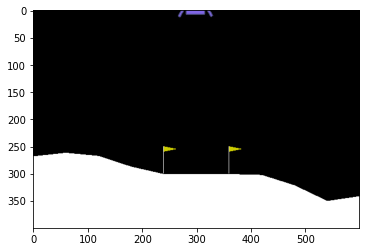

In [10]:
# Box2d Environment
env = gym.make('LunarLanderContinuous-v2')
env.reset()
plt.imshow(env.render('rgb_array'))


In [11]:
state_size = env.observation_space
print("state size is:", state_size)
a = env.action_space
print("action size=",a) 
state = env.reset()
print(state)   

state size is: Box(-inf, inf, (8,), float32)
action size= Box(-1.0, 1.0, (2,), float32)
[ 0.00748243  1.4012811   0.757856   -0.42842156 -0.0086633  -0.17166564
  0.          0.        ]


# Action Space
            #is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)

In [19]:
df = 0.9 #discount_factor
not_val = -999999
last_val = not_val
last_out = None
max_iterations = 3000

torch.autograd.set_detect_anomaly(True)
#mytestmodel.zero_grad()


In [20]:
policy_net =  model(layers).to(device)
target_net =  model(layers).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.SGD(policy_net.parameters(), lr=0.35, momentum=0.9)

In [ ]:
for a in range(1000):
    env = gym.make('LunarLanderContinuous-v2')
    env.reset()
    env = wrap_env(env)
    done = False
    iter = 0
    print(done)
    observation = state = env.reset()

    action = 1
    TotalReward = 0

    while not done and iter < max_iterations :
      iter +=1
      optimizer.zero_grad()
    #   action = env.action_space.sample()
      action =  random.choice(actions.all_actions)
      state_values = policy_net.forward(torch.from_numpy(observation))

      action = actions.get_action(state_values.argmax().item())
      observation, reward, done, _ = env.step(action)
      print("action is:",actions.get_full_action(state_values.argmax().item()) ,"reward: ",reward)
      next_values = target_net.forward(torch.from_numpy(observation))

      loss = F.smooth_l1_loss(state_values,torch.tensor([reward +df*next_values.max().item()], dtype=torch.float).unsqueeze(0) ) # Huber .unsqueeze(0)

      loss.backward()
      optimizer.step()


      TotalReward+= reward
      #print("state is:", observation)

      #if you want to see results on real-time 'open' the following 4 lines
    #   screen = env.render(mode='rgb_array')
    #   plt.imshow(screen)
    #   ipythondisplay.clear_output(wait=True)
    #   ipythondisplay.display(plt.gcf())


      if iter % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
    print(TotalReward,iter)

False
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.8336568807802109
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.6226205047328903
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.8432485703146995
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.29552436813023064
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.7716027008684136


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


action is: [[0, 0], 'Main off, Left Right off'] reward:  0.7059319513122375
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.553578209655774
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.6277124193699706
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.4366858571070906
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.336240846636656
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.2959709035469245
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.40626433821968244
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.066068414123731
action is: [[0, 0], 'Main off, Left Right off'] reward:  -2.323307614333146
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.4599621316535547
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.340453418495116
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.2226001363965395
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.11054990579552282
action i

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.4182723777047045
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.1240728886815248
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.1828629955230383
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.2321833574934544
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.0671222575792001
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.7021119671323106
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.2073598414249602
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.10488962529797732
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.114025042501396
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.08938327257379797
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.1919361365993666
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.2168696841284259
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.2349419851901189

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


reward:  -0.42703255183047306
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.3985519456041402
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.06049308997947947
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.4739810198766747
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.46807875646641717
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.4570138464441698
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.491116299401824
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.5151853141059632
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.529868482606986
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.7608969761801291
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.4565925682501699
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.5133674020794672
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.5081734089286556
action is: [[0, 0], 'Main off, Left Right off'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


action is: [[0, 0], 'Main off, Left Right off'] reward:  0.08317310288995827
action is: [[0, 0], 'Main off, Left Right off'] reward:  1.0146124888222232
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.6636965741882932
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.2335178760354779
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.23675306947288277
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.1386482634562924
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.7340693426666292
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.4285895321631358
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.6951164871925926
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.9410691465050774
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.025923760836406
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.3157546651125642
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.5258875916395596
act

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


action is: [[0, 0], 'Main off, Left Right off'] reward:  0.35190149651532465
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.9953835704809308
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.8727456753999605
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.1347819636732084
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.34970160063406297
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.32319702893414615
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.2901431632124343
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.7650093091264978
action is: [[0, 0], 'Main off, Left Right off'] reward:  -2.3471765812224987
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.24721905512737408
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.1984691031883301
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.4105937598758487
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.9346654654418274
a

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.31817877365155023
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.2935615457868608
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.391735765357879
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.4259344737953086
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.14976986299329836
action is: [[0, 0], 'Main off, Left Right off'] reward:  -0.888647924744447
action is: [[0, 0], 'Main off, Left Right off'] reward:  0.3168007935253513
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.4682347274664664
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.4793593914058079
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.483421503971897
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.4809404924658338
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.4725703551027038
action is: [[0, 0], 'Main off, Left Right off'] reward:  -1.4590524221465841
ac

In [ ]:
env.close()
show_video()

In [ ]:
print(iter)

In [ ]:
#Draw random samples from a normal (Gaussian) distribution.
mu, sigma = 0, 0.05 # mean and standard deviation
s = np.random.normal(mu, sigma, 1)
print(s)